In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# ## Plotly plotting support
# import plotly.plotly as py

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

# Lec-5: EDA and Data Cleaning (Demo)

Today, we will examine the process of data cleaning and Exploratory Data Analysis (EDA).  Often you will acquire or even be given a collection of data in order to conduct some analysis or answer some questions. The first step in using that data is to ensure that it is in the correct form (cleaned) and that you understand its properties and limitations (EDA). Often as you explore data through EDA you will identify additional transformations that may be required before the data is ready for analysis.

In this notebook, we obtain crime data from the city of Berkeley's public records.  Ultimately, our goal might be to understand policing patterns but before we get there we must first clean and understand the data. 

# Unboxing the Data

We have downloaded some data from the city of Berkeley's open data repositories and placed them in the data folder.  The first step to understanding the data is learning a bit about the files.

## How big is the data?

I often like to start my analysis by getting a rough estimate of the size of the data.  This will help inform the tools I use and how I view the data.  If it is relatively small I might use a text editor or a spreadsheet to look at the data.  If it is larger, I might jump to more programmatic exploration or even used distributed computing tools.

The following command lists (`l`) the files with human (`h`) readable file sizes:

In [63]:
ls -lh data

total 13936
-rw-r--r--@ 1 ihsan  staff   979K Aug 30  2017 Berkeley_PD_-_Calls_for_Service.csv
-rw-r--r--@ 1 ihsan  staff    81B Aug 30  2017 cvdow.csv
-rw-r--r--@ 1 ihsan  staff   5.8M Aug 30  2017 stops.json


You may also want to try the file command:

In [4]:
!file data/*

data/Berkeley_PD_-_Calls_for_Service.csv: ASCII text
data/cvdow.csv:                           ASCII text
data/stops.json:                          UTF-8 Unicode text, with very long lines


This command reveals a bit more about the structure of the data.

All the files are relatively small and we could comfortable examine them in a text editors.  (Personally, I like *sublime* or *emacs* but others may prefer a different *vi*ew.). 

In listing the files I noticed that the names suggest that they are all text file formats:
* **CSV**: Comma separated values is a very standard table format.
* **JSON**: JavaScript Object Notation is a very standard semi-structured file format used to store nested data.

We will dive into the formats in a moment.  However because these are text data I might also want to investigate the number of lines which often correspond to records.

Here I am invoking the shell command via the `!` operator.  The `wc` command computes the number of **lines**, **words**, and **characters** in each file:


In [6]:
!wc data/*

   16497   87732 1002706 data/Berkeley_PD_-_Calls_for_Service.csv
       8       8      81 data/cvdow.csv
   29852  658575 6124111 data/stops.json
   46357  746315 7126898 total


If we wanted to learn more about the command we could use the `man` (short for **manual**) command to read the manual page for `wc` (word count).

## Understanding the data generation
* What do the data contain? "crime incidents (not criminal reports) within the last 180 days". Further reading reveals that "not all calls for police service are included (e.g. Animal Bite)"."
* Are the data a census? (e.g., 180 days vs. 10 years)
* If the data form a sample, is it a probability sample?
* What limitations will this data have on our conclusions? (e.g., estimates about time periods not covered)

## What is the format?

We already noticed that the files end in `csv` and `json` which suggests that these are comma separated values and javascript object notation files.  However, we can't always rely on the naming as this is only a convention.  Often files will have incorrect extensions or no extension at all.

Let's assume that these are text files (and do not contain binary encoded data).  We could then use the `head` command to look at the first few lines in each file.

In [64]:
!head -n 10 data/Berkeley_PD_-_Calls_for_Service.csv

CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
17091420,BURGLARY AUTO,07/23/2017 12:00:00 AM,06:00,BURGLARY - VEHICLE,0,08/29/2017 08:28:05 AM,"2500 LE CONTE AVE
Berkeley, CA
(37.876965, -122.260544)",2500 LE CONTE AVE,Berkeley,CA
17020462,THEFT FROM PERSON,04/13/2017 12:00:00 AM,08:45,LARCENY,4,08/29/2017 08:28:00 AM,"2200 SHATTUCK AVE
Berkeley, CA
(37.869363, -122.268028)",2200 SHATTUCK AVE,Berkeley,CA
17050275,BURGLARY AUTO,08/24/2017 12:00:00 AM,18:30,BURGLARY - VEHICLE,4,08/29/2017 08:28:06 AM,"200 UNIVERSITY AVE
Berkeley, CA
(37.865491, -122.310065)",200 UNIVERSITY AVE,Berkeley,CA


### What are some observations about `Berkeley_PD_-_Calls_for_Service.csv`?

1. It appears to be in comma separated value (CSV) format.
1. First line contains the column headings
1. There are **"quoted"** strings in the `Block_Location` column:
```
"2500 LE CONTE AVE
Berkeley, CA
(37.876965, -122.260544)"
```
these are going to be difficult.  What are the implications on our earlier word count `wc` calculation?

---
<br/><br/><br/>

Examining the rest of the files:

In [6]:
!head -n 5 data/cvdow.csv

CVDOW,Day
0,Sunday
1,Monday
2,Tuesday
3,Wednesday


The `cvdow.csv` file is relatively small.  We can use the `cat` command to print out the entire file:

In [7]:
!cat data/cvdow.csv

CVDOW,Day
0,Sunday
1,Monday
2,Tuesday
3,Wednesday
4,Thursday
5,Friday
6,Saturday


Seems like a pretty standard well formatted CSV file.

# Reading About the Data

This is not always an option as:
1. There may be limited or no documentation.
1. Documentation may be out of date. (How will you know?)

In our case there is documentation for some of the datasets:
1. [Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5)
1. [Stop Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Stop-Data/6e9j-pj9p)

Here are summaries of the fields in the data:

### Calls Data
<img src="calls_desc.png" width=800px />

---
<br/><br/><br/>


# Loading the Data

We will now attempt to load the data into python.  We will be using the Pandas dataframe library for basic tabular data analysis.  Fortunately, the Pandas library has some relatively sophisticated functions for loading data. 

In [8]:
cvdow = pd.read_csv("data/cvdow.csv")
cvdow

CVDOW        Day
0      0     Sunday
1      1     Monday
2      2    Tuesday
3      3  Wednesday
4      4   Thursday
5      5     Friday
6      6   Saturday

This dataset is a **dictionary** which has a clear primary key `CVDOW`.  We will therefore set the index when loading the file.

In [9]:
cvdow = pd.read_csv("data/cvdow.csv").set_index("CVDOW")
cvdow

Day
CVDOW           
0         Sunday
1         Monday
2        Tuesday
3      Wednesday
4       Thursday
5         Friday
6       Saturday

Looks like a **dictionary** that defines the meaning of values for a field stored in another table.

---

<br/><br/><br/>
## Loading the Calls Data

Because the file appears to be a relatively well formatted CSV we will attempt to load it directly and allow the Pandas Library to deduce column headers.  (Always check that first row and column look correct after loading.)

In [10]:
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

CASENO            OFFENSE                 EVENTDT EVENTTM  \
0  17091420      BURGLARY AUTO  07/23/2017 12:00:00 AM   06:00   
1  17020462  THEFT FROM PERSON  04/13/2017 12:00:00 AM   08:45   
2  17050275      BURGLARY AUTO  08/24/2017 12:00:00 AM   18:30   
3  17019145         GUN/WEAPON  04/06/2017 12:00:00 AM   17:30   
4  17044993     VEHICLE STOLEN  08/01/2017 12:00:00 AM   18:00   

              CVLEGEND  CVDOW                InDbDate  \
0   BURGLARY - VEHICLE      0  08/29/2017 08:28:05 AM   
1              LARCENY      4  08/29/2017 08:28:00 AM   
2   BURGLARY - VEHICLE      4  08/29/2017 08:28:06 AM   
3      WEAPONS OFFENSE      4  08/29/2017 08:27:59 AM   
4  MOTOR VEHICLE THEFT      2  08/29/2017 08:28:05 AM   

                                      Block_Location             BLKADDR  \
0  2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...   2500 LE CONTE AVE   
1  2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...   2200 SHATTUCK AVE   
2  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...  200 UNIVERSITY AVE   
3  1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...     1900 SEVENTH ST   
4  100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...     100 PARKSIDE DR   

       City State  
0  Berkeley    CA  
1  Berkeley    CA  
2  Berkeley    CA  
3  Berkeley    CA  
4  Berkeley    CA

How many records did we get?

In [11]:
len(calls)

5508

On the surface the data looks easy to work with. However, before starting data analysis we must answer the following questions:

1. **Are there missing values in the dataset?** This question is important because missing values can represent many different things. For example, missing addresses could mean that locations were removed to protect anonymity, that a recording device broke, etc.
2. **Are there any missing values that were filled in (e.g. a 999 for unknown age or 12:00am for unknown date)?** These will clearly impact analysis if we ignore them.
3. **Which parts of the data were entered by a human?** As we will soon see, human-entered data is filled with inconsistencies and mispellings.

Ok, so let us get started with the first question. **Are there missing values in the data?**

In [12]:
null_rows = calls.isnull().any(axis=1)
calls[null_rows].count()

CASENO            27
OFFENSE           27
EVENTDT           27
EVENTTM           27
CVLEGEND          27
CVDOW             27
InDbDate          27
Block_Location    27
BLKADDR            0
City              27
State             27
dtype: int64

It looks like 27 calls didn't have a recorded address in BLKADDR.

**Are there any missing values that were filled in?**

In [13]:
calls.head()
calls[null_rows].head()

CASENO         OFFENSE                 EVENTDT EVENTTM  \
116   17014831   BURGLARY AUTO  03/16/2017 12:00:00 AM   22:00   
478   17042511   BURGLARY AUTO  07/20/2017 12:00:00 AM   16:00   
486   17022572  VEHICLE STOLEN  04/22/2017 12:00:00 AM   21:00   
724   17036936     DISTURBANCE  06/26/2017 12:00:00 AM   18:24   
1164  17034863     DISTURBANCE  06/01/2017 12:00:00 AM   00:00   

                 CVLEGEND  CVDOW                InDbDate  \
116    BURGLARY - VEHICLE      4  08/29/2017 08:27:58 AM   
478    BURGLARY - VEHICLE      4  08/29/2017 08:28:05 AM   
486   MOTOR VEHICLE THEFT      6  08/29/2017 08:28:00 AM   
724    DISORDERLY CONDUCT      1  08/29/2017 08:28:03 AM   
1164   DISORDERLY CONDUCT      4  08/29/2017 08:28:02 AM   

                              Block_Location BLKADDR      City State  
116   Berkeley, CA\n(37.869058, -122.270455)     NaN  Berkeley    CA  
478   Berkeley, CA\n(37.869058, -122.270455)     NaN  Berkeley    CA  
486   Berkeley, CA\n(37.869058, -122.270455)     NaN  Berkeley    CA  
724   Berkeley, CA\n(37.869058, -122.270455)     NaN  Berkeley    CA  
1164  Berkeley, CA\n(37.869058, -122.270455)     NaN  Berkeley    CA

### Preliminary observations on the data?

1. `EVENTDT` -- Contain the incorrect time stamp
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `InDbDate` -- Appears to be correctly formatted and appears consistent in time.
1. **`Block_Location` -- Errr, what a mess!  newline characters, and Geocoordinates all merged!!  Fortunately, this field was "quoted" otherwise we would have had trouble parsing the file. (why?)**
1. `BLKADDR` -- This appears to be the address in Block Location.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.

--- 
<br/><br/><br/>

### Joining the Day of the Week Dictionary

In [14]:
calls.drop("Day", axis=1, inplace=True, errors='ignore')
calls['Day'] = calls.join(cvdow, on='CVDOW')['Day']
calls.head()

CASENO            OFFENSE                 EVENTDT EVENTTM  \
0  17091420      BURGLARY AUTO  07/23/2017 12:00:00 AM   06:00   
1  17020462  THEFT FROM PERSON  04/13/2017 12:00:00 AM   08:45   
2  17050275      BURGLARY AUTO  08/24/2017 12:00:00 AM   18:30   
3  17019145         GUN/WEAPON  04/06/2017 12:00:00 AM   17:30   
4  17044993     VEHICLE STOLEN  08/01/2017 12:00:00 AM   18:00   

              CVLEGEND  CVDOW                InDbDate  \
0   BURGLARY - VEHICLE      0  08/29/2017 08:28:05 AM   
1              LARCENY      4  08/29/2017 08:28:00 AM   
2   BURGLARY - VEHICLE      4  08/29/2017 08:28:06 AM   
3      WEAPONS OFFENSE      4  08/29/2017 08:27:59 AM   
4  MOTOR VEHICLE THEFT      2  08/29/2017 08:28:05 AM   

                                      Block_Location             BLKADDR  \
0  2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...   2500 LE CONTE AVE   
1  2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...   2200 SHATTUCK AVE   
2  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...  200 UNIVERSITY AVE   
3  1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...     1900 SEVENTH ST   
4  100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...     100 PARKSIDE DR   

       City State       Day  
0  Berkeley    CA    Sunday  
1  Berkeley    CA  Thursday  
2  Berkeley    CA  Thursday  
3  Berkeley    CA  Thursday  
4  Berkeley    CA   Tuesday

In [15]:
grp_day = calls.groupby("Day")
grp_day.count()

CASENO  OFFENSE  EVENTDT  EVENTTM  CVLEGEND  CVDOW  InDbDate  \
Day                                                                       
Friday        831      831      831      831       831    831       831   
Monday        788      788      788      788       788    788       788   
Saturday      832      832      832      832       832    832       832   
Sunday        718      718      718      718       718    718       718   
Thursday      784      784      784      784       784    784       784   
Tuesday       790      790      790      790       790    790       790   
Wednesday     765      765      765      765       765    765       765   

           Block_Location  BLKADDR  City  State  
Day                                              
Friday                831      827   831    831  
Monday                788      785   788    788  
Saturday              832      830   832    832  
Sunday                718      712   718    718  
Thursday              784      780   784    784  
Tuesday               790      784   790    790  
Wednesday             765      763   765    765

As a data cleaning step, we want to merge the EVENTDT and EVENTTM columns to record both date and time in one field. If we define a function that takes in a DF and returns a new DF, we can later use pd.pipe to apply all transformations in one go.

In [16]:
def combine_event_datetimes(calls):
    combined = pd.to_datetime(
        # Combine date and time strings
        calls['EVENTDT'].str[:10] + ' ' + calls['EVENTTM'],
        infer_datetime_format=True,
    )
    return calls.assign(EVENTDTTM=combined)

# To peek at the result without mutating the calls DF:
calls.pipe(combine_event_datetimes).head(2)

CASENO            OFFENSE                 EVENTDT EVENTTM  \
0  17091420      BURGLARY AUTO  07/23/2017 12:00:00 AM   06:00   
1  17020462  THEFT FROM PERSON  04/13/2017 12:00:00 AM   08:45   

             CVLEGEND  CVDOW                InDbDate  \
0  BURGLARY - VEHICLE      0  08/29/2017 08:28:05 AM   
1             LARCENY      4  08/29/2017 08:28:00 AM   

                                      Block_Location            BLKADDR  \
0  2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...  2500 LE CONTE AVE   
1  2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...  2200 SHATTUCK AVE   

       City State       Day           EVENTDTTM  
0  Berkeley    CA    Sunday 2017-07-23 06:00:00  
1  Berkeley    CA  Thursday 2017-04-13 08:45:00

---

<br/><br/><br/>

# Cleaning Block Location

The block location contains the GPS coordinates and I would like to use these to analyze the location of each request.  Let's try to extract the GPS coordinates using regular expressions (we will cover regular expressions in future lectures):


In [17]:
calls_lat_lon = (
    # Remove newlines
    calls['Block_Location'].str.replace("\n", "\t") 
    # Extract Lat and Lon using regular expression
    .str.extract(".*\((?P<Lat>\d*\.\d*)\, (?P<Lon>-?\d*.\d*)\)",expand=True)
)
calls_lat_lon.head()

Lat          Lon
0  37.876965  -122.260544
1  37.869363  -122.268028
2  37.865491  -122.310065
3  37.869318  -122.296984
4  37.854247   -122.24375

The following block of code joins the extracted Latitude and Longitude fields with the calls data.  Notice that we actually drop these fields before joining.  This is to enable repeated invocation of this cell even after the join has been completed.  (Not necessary but a good habit.)

In [18]:
# Remove Lat and Lon if they already existed before (reproducible)
calls.drop(["Lat", "Lon"], axis=1, inplace=True, errors="ignore")
# Join in the the latitude and longitude data
calls = calls.join(calls_lat_lon)
calls.head()

CASENO            OFFENSE                 EVENTDT EVENTTM  \
0  17091420      BURGLARY AUTO  07/23/2017 12:00:00 AM   06:00   
1  17020462  THEFT FROM PERSON  04/13/2017 12:00:00 AM   08:45   
2  17050275      BURGLARY AUTO  08/24/2017 12:00:00 AM   18:30   
3  17019145         GUN/WEAPON  04/06/2017 12:00:00 AM   17:30   
4  17044993     VEHICLE STOLEN  08/01/2017 12:00:00 AM   18:00   

              CVLEGEND  CVDOW                InDbDate  \
0   BURGLARY - VEHICLE      0  08/29/2017 08:28:05 AM   
1              LARCENY      4  08/29/2017 08:28:00 AM   
2   BURGLARY - VEHICLE      4  08/29/2017 08:28:06 AM   
3      WEAPONS OFFENSE      4  08/29/2017 08:27:59 AM   
4  MOTOR VEHICLE THEFT      2  08/29/2017 08:28:05 AM   

                                      Block_Location             BLKADDR  \
0  2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...   2500 LE CONTE AVE   
1  2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...   2200 SHATTUCK AVE   
2  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...  200 UNIVERSITY AVE   
3  1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...     1900 SEVENTH ST   
4  100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...     100 PARKSIDE DR   

       City State       Day        Lat          Lon  
0  Berkeley    CA    Sunday  37.876965  -122.260544  
1  Berkeley    CA  Thursday  37.869363  -122.268028  
2  Berkeley    CA  Thursday  37.865491  -122.310065  
3  Berkeley    CA  Thursday  37.869318  -122.296984  
4  Berkeley    CA   Tuesday  37.854247   -122.24375

--- 

<br/><br/><br/>

# EDA 

Now that we have loaded our various data files.  Let's try to understand a bit more about the data by examining properties of individual fields.

## EDA on the Calls Data

In [19]:
calls.head(7)

CASENO               OFFENSE                 EVENTDT EVENTTM  \
0  17091420         BURGLARY AUTO  07/23/2017 12:00:00 AM   06:00   
1  17020462     THEFT FROM PERSON  04/13/2017 12:00:00 AM   08:45   
2  17050275         BURGLARY AUTO  08/24/2017 12:00:00 AM   18:30   
3  17019145            GUN/WEAPON  04/06/2017 12:00:00 AM   17:30   
4  17044993        VEHICLE STOLEN  08/01/2017 12:00:00 AM   18:00   
5  17037319  BURGLARY RESIDENTIAL  06/28/2017 12:00:00 AM   12:00   
6  17030791  BURGLARY RESIDENTIAL  05/30/2017 12:00:00 AM   08:45   

                 CVLEGEND  CVDOW                InDbDate  \
0      BURGLARY - VEHICLE      0  08/29/2017 08:28:05 AM   
1                 LARCENY      4  08/29/2017 08:28:00 AM   
2      BURGLARY - VEHICLE      4  08/29/2017 08:28:06 AM   
3         WEAPONS OFFENSE      4  08/29/2017 08:27:59 AM   
4     MOTOR VEHICLE THEFT      2  08/29/2017 08:28:05 AM   
5  BURGLARY - RESIDENTIAL      3  08/29/2017 08:28:03 AM   
6  BURGLARY - RESIDENTIAL      2  08/29/2017 08:28:00 AM   

                                      Block_Location             BLKADDR  \
0  2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...   2500 LE CONTE AVE   
1  2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...   2200 SHATTUCK AVE   
2  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...  200 UNIVERSITY AVE   
3  1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...     1900 SEVENTH ST   
4  100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...     100 PARKSIDE DR   
5  1500 PRINCE ST\nBerkeley, CA\n(37.851503, -122...      1500 PRINCE ST   
6                       300 MENLO PL\nBerkeley, CA\n        300 MENLO PL   

       City State        Day        Lat          Lon  
0  Berkeley    CA     Sunday  37.876965  -122.260544  
1  Berkeley    CA   Thursday  37.869363  -122.268028  
2  Berkeley    CA   Thursday  37.865491  -122.310065  
3  Berkeley    CA   Thursday  37.869318  -122.296984  
4  Berkeley    CA    Tuesday  37.854247   -122.24375  
5  Berkeley    CA  Wednesday  37.851503  -122.278518  
6  Berkeley    CA    Tuesday        NaN          NaN

---
<br/><br/><br/>

### Are Case Numbers unique?

Case numbers are probably used internally to track individual cases and my reference other data we don't have access to.  However, it is possible that multiple calls could be associated with the same case.  Let's see if the case numbers are all unique.

In [20]:
print("There are", len(calls['CASENO'].unique()), "unique case numbers.")
print("There are", len(calls), "calls in the table.")

There are 5508 unique case numbers.
There are 5508 calls in the table.


Are case numbers assigned consecutively.  

Text(0, 0.5, 'Case Number')

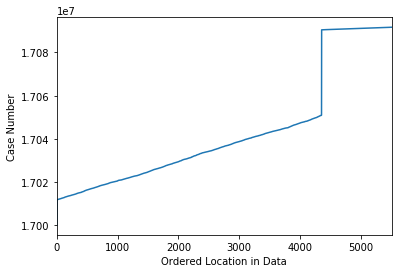

In [21]:
calls['CASENO'].sort_values().reset_index(drop=True).plot()
plt.xlabel("Ordered Location in Data")
plt.ylabel("Case Number")

In [22]:
import seaborn as sns
sns.set()
sns.distplot(calls['CASENO'])

### What might we be observing?

One possible explanation is that case numbers were assigned consecutively and then sampled uniformly at different rates for two different periods.  We will be able to understand this better by looking at the dates on the cases.

---
<br/><br/><br/>

## Examining the Date

Given the weird behavior with the case numbers let's dig into the date in which events were recorded.  Notice in this data we have several pieces of date/time information (this is not uncommon):
1. **`EVENTDT`**: This contains the date the event took place.  While it has time information the time appears to be `00:00:00`.  
1. **`EVENTTM`**: This contains the time at which the event took place.
1. **`InDbDate`**: This appears to be the date at which the data was entered in the database.  

In [23]:
calls.head(3)

CASENO            OFFENSE                 EVENTDT EVENTTM  \
0  17091420      BURGLARY AUTO  07/23/2017 12:00:00 AM   06:00   
1  17020462  THEFT FROM PERSON  04/13/2017 12:00:00 AM   08:45   
2  17050275      BURGLARY AUTO  08/24/2017 12:00:00 AM   18:30   

             CVLEGEND  CVDOW                InDbDate  \
0  BURGLARY - VEHICLE      0  08/29/2017 08:28:05 AM   
1             LARCENY      4  08/29/2017 08:28:00 AM   
2  BURGLARY - VEHICLE      4  08/29/2017 08:28:06 AM   

                                      Block_Location             BLKADDR  \
0  2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...   2500 LE CONTE AVE   
1  2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...   2200 SHATTUCK AVE   
2  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...  200 UNIVERSITY AVE   

       City State       Day        Lat          Lon  
0  Berkeley    CA    Sunday  37.876965  -122.260544  
1  Berkeley    CA  Thursday  37.869363  -122.268028  
2  Berkeley    CA  Thursday  37.865491  -122.310065

When Pandas loads more complex fields like dates it will often load them as strings:

In [24]:
calls["EVENTDT"][0]

'07/23/2017 12:00:00 AM'

We will want to convert these to dates.  Pandas has a fairly sophisticated function `pd.to_datetime` which is capable of guessing reasonable conversions of dates to date objects. 

In [25]:
dates = pd.to_datetime(calls["EVENTDT"])

We can verify that the translations worked by looking at a few dates:

In [26]:
pd.DataFrame(dict(transformed=dates, original=calls["EVENTDT"])).head()

transformed                original
0  2017-07-23  07/23/2017 12:00:00 AM
1  2017-04-13  04/13/2017 12:00:00 AM
2  2017-08-24  08/24/2017 12:00:00 AM
3  2017-04-06  04/06/2017 12:00:00 AM
4  2017-08-01  08/01/2017 12:00:00 AM

We can also extract the time field:

In [27]:
times = pd.to_datetime(calls["EVENTTM"]).dt.time
times.head()

0    06:00:00
1    08:45:00
2    18:30:00
3    17:30:00
4    18:00:00
Name: EVENTTM, dtype: object

To combine the correct date and correct time field we use the built-in python datetime combine function.

In [28]:
from datetime import datetime
timestamps = pd.to_datetime(pd.concat([dates, times], axis=1).apply(
    lambda r: datetime.combine(r['EVENTDT'], r['EVENTTM']), axis=1))
timestamps.head()

0   2017-07-23 06:00:00
1   2017-04-13 08:45:00
2   2017-08-24 18:30:00
3   2017-04-06 17:30:00
4   2017-08-01 18:00:00
dtype: datetime64[ns]

We now updated calls to contain this additional informations:

In [29]:
calls['timestamp'] = timestamps
calls.head()

CASENO            OFFENSE                 EVENTDT EVENTTM  \
0  17091420      BURGLARY AUTO  07/23/2017 12:00:00 AM   06:00   
1  17020462  THEFT FROM PERSON  04/13/2017 12:00:00 AM   08:45   
2  17050275      BURGLARY AUTO  08/24/2017 12:00:00 AM   18:30   
3  17019145         GUN/WEAPON  04/06/2017 12:00:00 AM   17:30   
4  17044993     VEHICLE STOLEN  08/01/2017 12:00:00 AM   18:00   

              CVLEGEND  CVDOW                InDbDate  \
0   BURGLARY - VEHICLE      0  08/29/2017 08:28:05 AM   
1              LARCENY      4  08/29/2017 08:28:00 AM   
2   BURGLARY - VEHICLE      4  08/29/2017 08:28:06 AM   
3      WEAPONS OFFENSE      4  08/29/2017 08:27:59 AM   
4  MOTOR VEHICLE THEFT      2  08/29/2017 08:28:05 AM   

                                      Block_Location             BLKADDR  \
0  2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...   2500 LE CONTE AVE   
1  2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...   2200 SHATTUCK AVE   
2  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...  200 UNIVERSITY AVE   
3  1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...     1900 SEVENTH ST   
4  100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...     100 PARKSIDE DR   

       City State       Day        Lat          Lon           timestamp  
0  Berkeley    CA    Sunday  37.876965  -122.260544 2017-07-23 06:00:00  
1  Berkeley    CA  Thursday  37.869363  -122.268028 2017-04-13 08:45:00  
2  Berkeley    CA  Thursday  37.865491  -122.310065 2017-08-24 18:30:00  
3  Berkeley    CA  Thursday  37.869318  -122.296984 2017-04-06 17:30:00  
4  Berkeley    CA   Tuesday  37.854247   -122.24375 2017-08-01 18:00:00

### What time range does the data represent

In [30]:
calls['timestamp'].min()

Timestamp('2017-03-02 02:00:00')

In [31]:
calls['timestamp'].max()

Timestamp('2017-08-28 09:35:00')

---
<br/><br/><br/>

### Back to the Case Numbers

#### Explanation?

Perhaps there are multiple different record books with different numbering schemes?  This might be something worth investigating further.

---
<br/><br/><br/>


## Are there any other interesting temporal patterns

Do more calls occur on a particular day of the week?

In [53]:
#calls['Day'].plot.hist(bins=30)

calls.groupby('Day').size()

Day
Friday       831
Monday       788
Saturday     832
Sunday       718
Thursday     784
Tuesday      790
Wednesday    765
dtype: int64

How about temporal patterns within a day

In [54]:
ts = calls['timestamp']
minute_of_day = ts.dt.hour * 60 + ts.dt.minute
hour_of_day = minute_of_day / 60.

calls['minute_of_day'] = minute_of_day
calls['hour_of_day'] = hour_of_day

In [55]:
sns.distplot(calls['hour_of_day'])

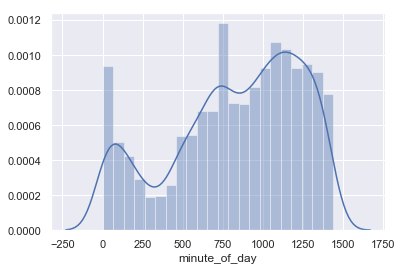

In [36]:
sns.distplot(calls['minute_of_day'])

### Observations?

In the above plot we see the standard pattern of limited activity early in the morning around here 6:00AM.

### Smoothing Parameters

In the above plot we see a smoothed curve approximating the histogram.  This is an example of a kernel density estimator (KDE).  The KDE, like the histogram, has a parameter that determines it's smoothness.  Many packages (Plotly and Seaborn) use a boostrap like procedure to choose the best value.  

To understand how this parameter works we will use seaborn which let's you also set the parameter manually.  

In [37]:
sns.distplot(hour_of_day, kde_kws=dict(bw=.1), rug=False)

Notice in the above plot that the interpolation tries to follow the histogram to closely. 

## Where are most crime incidents taking place?

In [62]:
calls['BLKADDR'].value_counts()

2100 SHATTUCK AVE                   76
2800 ADELINE ST                     57
1900 SHATTUCK AVE                   52
2300 TELEGRAPH AVE                  49
2200 SHATTUCK AVE                   45
2400 DURANT AVE                     45
100 SEAWALL DR                      39
2000 OREGON ST                      39
1000 GILMAN ST                      36
2500 DURANT AVE                     34
200 UNIVERSITY AVE                  32
1300 SAN PABLO AVE                  31
1400 SHATTUCK AVE                   30
2500 TELEGRAPH AVE                  30
2000 ALLSTON WAY                    29
900 HEINZ AVE                       29
2100 KITTREDGE ST                   27
2300 SHATTUCK AVE                   27
200 MARINA BLVD                     26
2100 M L KING JR WAY                26
1100 UNIVERSITY AVE                 25
1700 FOURTH ST                      25
2000 CENTER ST                      25
2600 TELEGRAPH AVE                  24
2300 FOURTH ST                      23
2000 UNIVERSITY AVE      

#### Observations?

Car burglary and misdemeanor theft seem to be the most common crimes with many other types of crimes occurring rarely.

In [38]:
calls.head()

CASENO            OFFENSE                 EVENTDT EVENTTM  \
0  17091420      BURGLARY AUTO  07/23/2017 12:00:00 AM   06:00   
1  17020462  THEFT FROM PERSON  04/13/2017 12:00:00 AM   08:45   
2  17050275      BURGLARY AUTO  08/24/2017 12:00:00 AM   18:30   
3  17019145         GUN/WEAPON  04/06/2017 12:00:00 AM   17:30   
4  17044993     VEHICLE STOLEN  08/01/2017 12:00:00 AM   18:00   

              CVLEGEND  CVDOW                InDbDate  \
0   BURGLARY - VEHICLE      0  08/29/2017 08:28:05 AM   
1              LARCENY      4  08/29/2017 08:28:00 AM   
2   BURGLARY - VEHICLE      4  08/29/2017 08:28:06 AM   
3      WEAPONS OFFENSE      4  08/29/2017 08:27:59 AM   
4  MOTOR VEHICLE THEFT      2  08/29/2017 08:28:05 AM   

                                      Block_Location             BLKADDR  \
0  2500 LE CONTE AVE\nBerkeley, CA\n(37.876965, -...   2500 LE CONTE AVE   
1  2200 SHATTUCK AVE\nBerkeley, CA\n(37.869363, -...   2200 SHATTUCK AVE   
2  200 UNIVERSITY AVE\nBerkeley, CA\n(37.865491, ...  200 UNIVERSITY AVE   
3  1900 SEVENTH ST\nBerkeley, CA\n(37.869318, -12...     1900 SEVENTH ST   
4  100 PARKSIDE DR\nBerkeley, CA\n(37.854247, -12...     100 PARKSIDE DR   

       City State       Day        Lat          Lon           timestamp  \
0  Berkeley    CA    Sunday  37.876965  -122.260544 2017-07-23 06:00:00   
1  Berkeley    CA  Thursday  37.869363  -122.268028 2017-04-13 08:45:00   
2  Berkeley    CA  Thursday  37.865491  -122.310065 2017-08-24 18:30:00   
3  Berkeley    CA  Thursday  37.869318  -122.296984 2017-04-06 17:30:00   
4  Berkeley    CA   Tuesday  37.854247   -122.24375 2017-08-01 18:00:00   

   minute_of_day  hour_of_day  
0            360         6.00  
1            525         8.75  
2           1110        18.50  
3           1050        17.50  
4           1080        18.00

In [39]:
calls.groupby('OFFENSE').size()

OFFENSE
2ND RESPONSE                  46
ALCOHOL OFFENSE              147
ARSON                         14
ASSAULT/BATTERY FEL.          91
ASSAULT/BATTERY MISD.        261
BRANDISHING                   31
BURGLARY AUTO               1021
BURGLARY COMMERCIAL          104
BURGLARY RESIDENTIAL         274
DISTURBANCE                  414
DOMESTIC VIOLENCE            130
FRAUD/FORGERY                100
GUN/WEAPON                    46
HOMICIDE                       1
IDENTITY THEFT               160
KIDNAPPING                     1
MISSING ADULT                 68
MISSING JUVENILE              28
MUNICIPAL CODE                 9
NARCOTICS                    328
ROBBERY                      187
SEXUAL ASSAULT FEL.           30
SEXUAL ASSAULT MISD.          20
THEFT FELONY (OVER $950)     238
THEFT FROM AUTO              140
THEFT FROM PERSON             22
THEFT MISD. (UNDER $950)     842
VANDALISM                    438
VEHICLE RECOVERED              8
VEHICLE STOLEN               308
VI

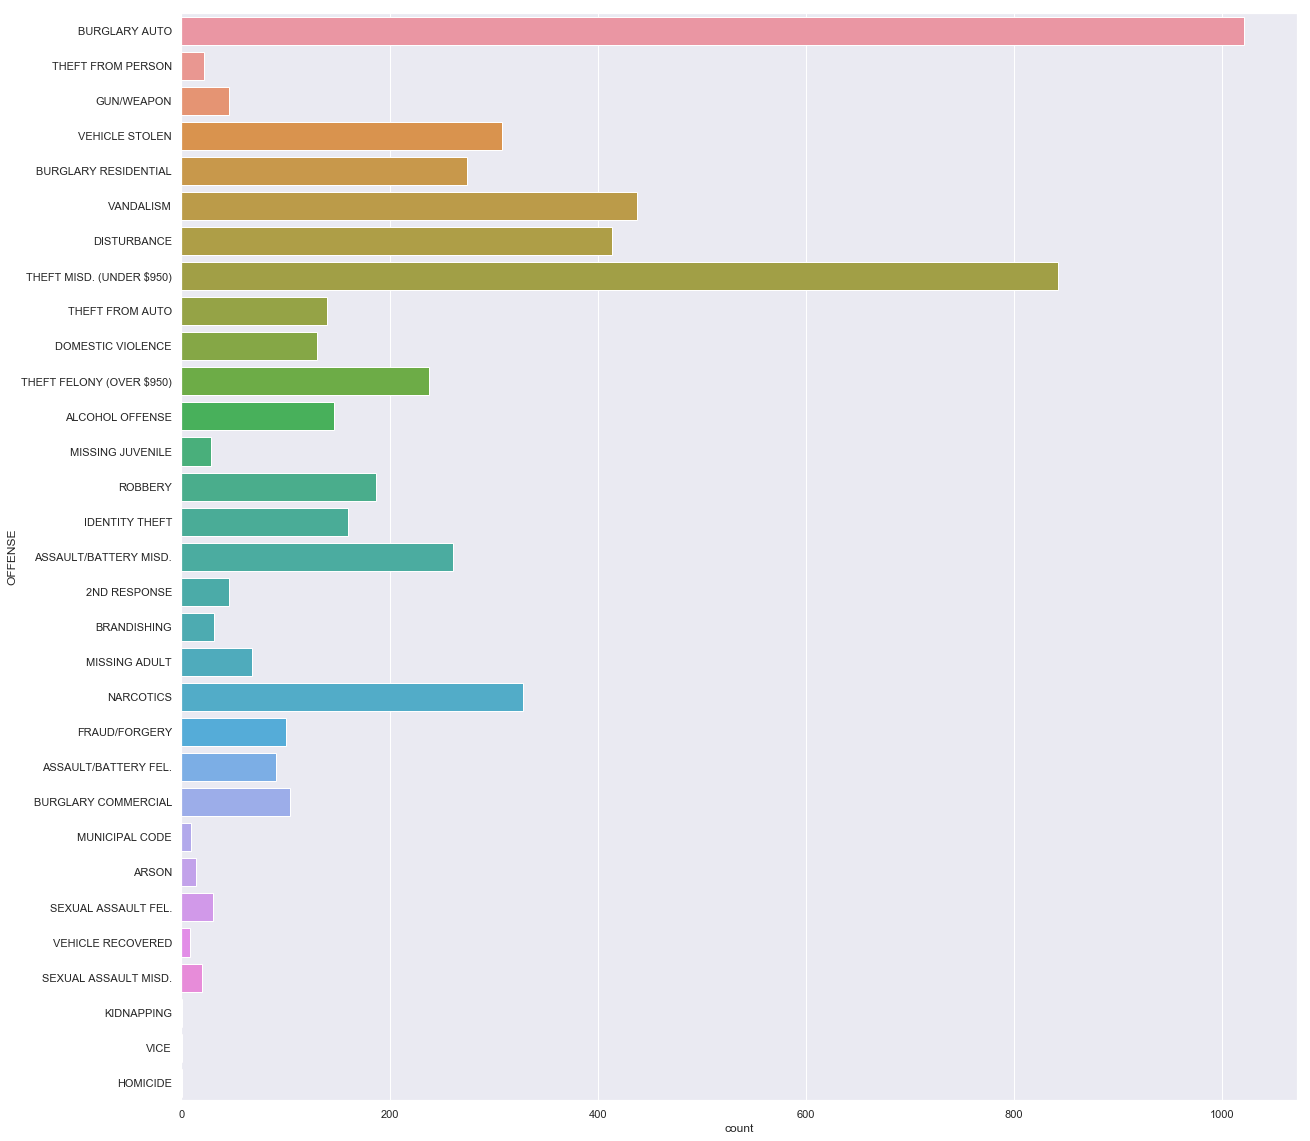

In [51]:
#calls.groupby('OFFENSE').size().plot.hist(bins=30)
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,1,1)
sns.countplot(y='OFFENSE', data=calls)